## Knowledge Graphs

By: Thierno Diallo

In this notebook we walkthorugth visualizations of relational data as Knowledge Graphs alongside implemnetations of Graph Convolutional Networks to classify entities (nodes) and predict relations between entities (edges). Please find linked the notebooks used for this walkthrough alongside the original paper on the topic:
- Predicting Relations By Haoxin Li: https://github.com/mims-harvard/graphml-tutorials/blob/master/README.md
- Classifying Nodes: https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing
- Original Paper: https://arxiv.org/pdf/1703.06103

# Node Classification on large Knowledge Graphs

In this exercise, we look at the the **Cora Dataset** which serves as benchmark for graph-based learning.  It comprises 2,708 scientific publications categorized into one of seven classes:

*  Case-Based
*  Genetic Algorithms
*  Neural Networks
*  Probabilistic Methods
*  Reinforcement Learning
*  Rule Learning
*  Theory

Each publication is represented by a binary word vector of length 1,433, indicating the presence or absence of specific words from a predefined dictionary. The dataset includes a citation network with 5,429 links, where each directed edge denotes a citation from one paper to another and each paper represnts a node in our directed graph.

## Data Loading and Visualization

In [ ]:
# Download dependencies
# Check CUDA Version
!python -c "import torch; print(torch.version.cuda)"

# Install Pytorch Geometric
!pip install torch torch_geometric matplotlib pandas networkx #torch-sparse

12.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of Citations: 2708
Number of Edges: 10556
Citations Per Catagory:
 0    351
1    217
2    418
3    818
4    426
5    298
6    180
Name: count, dtype: int64


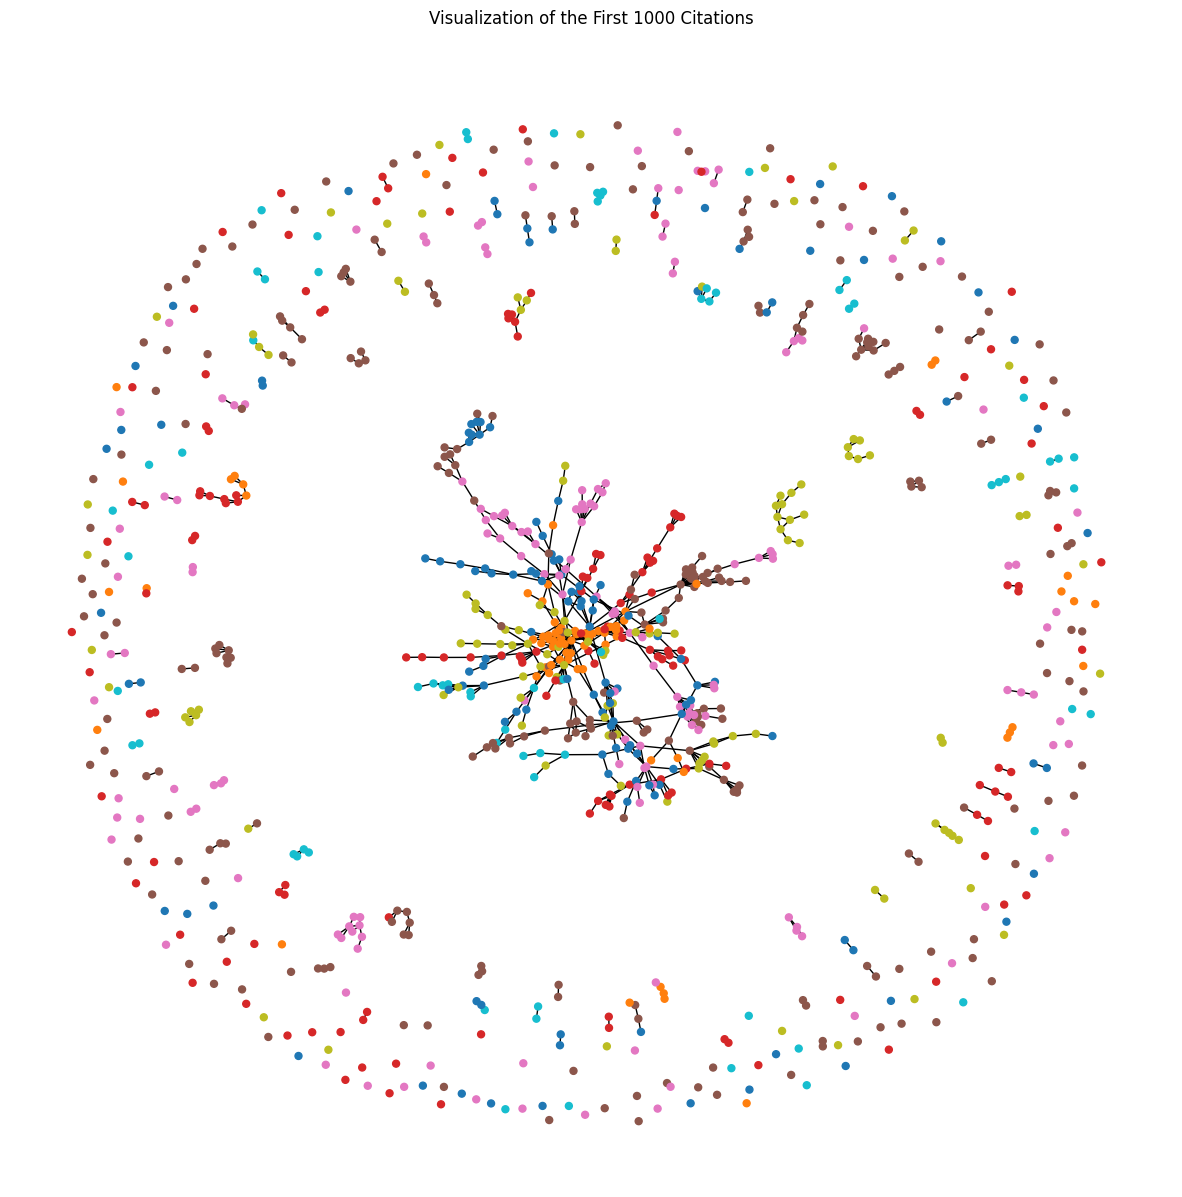

In [ ]:
# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]
print(f'Number of Citations: {data.num_nodes}')
print(f'Number of Edges: {data.num_edges}')
print("Citations Per Catagory:\n",pd.Series(data.y.numpy()).value_counts().sort_index())
print(50*'=')

# Convert our data into an undirected graph for plotting
graph = to_networkx(data, to_undirected=True)

# Select the first N nodes for visualization
N = 1000
subset_nodes = list(range(N))
subset_graph = graph.subgraph(subset_nodes)


# Visualize the subgraph
plt.figure(figsize=(15, 15))
plt.title(f"Visualization of the First {N} Citations")
pos = nx.spring_layout(subset_graph, seed=42)  # Positioning for better visualization
nx.draw(
    subset_graph,
    pos,
    node_size=25,
    node_color=[data.y[node] for node in subset_nodes],
    cmap=plt.cm.tab10,
    font_size=8,
)
plt.show()
# What are the relations in the below graph? How can we connect this to our
# understanding of knowledge graphs?

## Node Classifcation **Without** Considering Knowledege Graph

Here we consider a baseline Multi Layer Perceptron model that does not take into account the citations, but rather will take the node features as input and predict the class label of nodes. Here, we are not considering the graph structure of how nodes are related through citations to form baseline that we can compare our Graph Convolutional Network to. You can implement any such model of your choice below, however, **for the solution we will implement an MLP model with two fully connected models**.

In [ ]:
# Extract Features
x = data.x # Node Features
y = data.y # Node Labels

# Split data into training, validation, and test
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

# Create an MLP baseline model of your choice with fully connected layers.
class MLP(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(in_channels, hidden_channels)
    self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

# Initialize MLP baseline model
in_channels = dataset.num_features # Node Features
hidden_channels = 64 # How many hidden layes dow we want
out_channels = dataset.num_classes # Number of classes
baseline_model = MLP(in_channels, hidden_channels, out_channels)

# Define Optimizer
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.01)
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Train Model
def train(data, epochs=100):
  baseline_model.train()
  for epoch in range(epochs):
    optimizer.zero_grad() # Optimzer
    out = baseline_model(data.x) # Forward Propagate
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Compute Loss
    loss.backward()  # back propagate
    optimizer.step() # update model weights

    # Print Epoch, Loss, and Training Accuracy every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
      pred = out.argmax(dim=1)
      correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
      acc = int(correct) / int(data.train_mask.sum())
      print(f"Epoch {epoch+1:03d}, Loss: {loss:.4f}, Train Accuracy: {acc:.4f}")

train(data)


Epoch 001, Loss: 1.9498, Train Accuracy: 0.1429
Epoch 010, Loss: 1.7314, Train Accuracy: 1.0000
Epoch 020, Loss: 1.1295, Train Accuracy: 1.0000
Epoch 030, Loss: 0.4318, Train Accuracy: 1.0000
Epoch 040, Loss: 0.1063, Train Accuracy: 1.0000
Epoch 050, Loss: 0.0308, Train Accuracy: 1.0000
Epoch 060, Loss: 0.0141, Train Accuracy: 1.0000
Epoch 070, Loss: 0.0090, Train Accuracy: 1.0000
Epoch 080, Loss: 0.0068, Train Accuracy: 1.0000
Epoch 090, Loss: 0.0056, Train Accuracy: 1.0000
Epoch 100, Loss: 0.0049, Train Accuracy: 1.0000


In [ ]:
# Lets Evaluate our model
def evaluate_model(data):
  baseline_model.eval()
  with torch.no_grad():
    out = baseline_model(data.x)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f"Test Accuracy: {acc:.4f}")

pred = evaluate_model(data)

Test Accuracy: 0.5340


## Graph Convolutional Network for Node Classification

Now we will construct a Graph Neural Network that considers these relations and compare the test accuracy with that of the MLP. We will implment a simple 2 layer GCN for this walkthrough, however, feel free to modify the netwrok to improve evalution acuracy.

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


## Training and Evaluation

In [ ]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8616
Epoch: 200, Loss: 1.7218
Epoch: 300, Loss: 1.6939
Epoch: 400, Loss: 1.6406
Epoch: 500, Loss: 1.5496
Epoch: 600, Loss: 1.4957
Epoch: 700, Loss: 1.4611
Epoch: 800, Loss: 1.4322
Epoch: 900, Loss: 1.3927
Epoch: 1000, Loss: 1.3463


In [ ]:
# Evaluate model
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      print(f"Test Accuracy: {test_acc:.4f}")

test()

# Why do you think we are seeing this increased test accuracy?

0.702

# Multi-relational Link Prediction on Knowledge Graphs

Now that we have seen node classifcation with knowledge graphs, we will look at link (edge) predicition on knowledge graphs using Relational Graph Convolutional Neural Networks (RGCN) as proposed on the original paper. We will apply this architecture to a biological dataset where each node is a protein or drug and each edge represents the intractions between nodes. Here, we have multi-relational links as we do not have the same interaction between all nodes the time. We will explore this deeper when discussing the dataset.

**Motivations:** In the biological world, different types of relation could exist between two entities. For example, a drug/chemical compound can act as a *target, enzyme, carrier* or *transporter* on proteins, forming 4 types of edges. Thus, it would not be ideal to represent these relations using the same edge embeddings.

### Set Up Files And Download Dependencies

In [ ]:
# Imports
import torch
import os
import torch

# Mount GPU. Please make sure that you are connected to a runtime
# GPU for this exercise.
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device:", torch.device("cuda:0"))
else:
    print("GPU is not available. Using CPU instead.")

# Download torch dependencies
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

GPU is not available. Using CPU instead.
2.5.1+cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.0/544.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 15.5 MB/s eta 0:00:00


In [ ]:
# Import dependencies
from torch_geometric.data import Data, GraphSAINTRandomWalkSampler, NeighborSampler, GraphSAINTEdgeSampler
from torch_geometric.nn import RGCNConv, Node2Vec, FastRGCNConv
from torch_geometric.utils import contains_isolated_nodes

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

In [ ]:
# Want to save in data files similar to github
data_dir = '/content/data'
os.makedirs(data_dir, exist_ok=True)

# List of data files to download
data_files = [
    'edge_index.pt',
    'edge_attr.pt',
    'edge_meta_type.pt',
    'edge_type.pt',
    'x.pt',
    'y.pt',
    'train_mask.pt',
    'val_mask.pt',
    'test_mask.pt'
]

# Base URL of the GitHub repository
base_url = 'https://github.com/mims-harvard/graphml-tutorials/raw/master/02-KG/data/'

# Download each file
for file_name in data_files:
    file_url = base_url + file_name
    !wget -P {data_dir} {file_url}


--2024-11-27 02:03:05--  https://github.com/mims-harvard/graphml-tutorials/raw/master/02-KG/data/edge_index.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mims-harvard/graphml-tutorials/master/02-KG/data/edge_index.pt [following]
--2024-11-27 02:03:05--  https://raw.githubusercontent.com/mims-harvard/graphml-tutorials/master/02-KG/data/edge_index.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24244445 (23M) [application/octet-stream]
Saving to: ‘/content/data/edge_index.pt’

edge_index.pt       100%[===================>]  23.12M   129MB/s    in 0.2s    

2024-11-27 02:03:06 (129 MB/s) - 

### Preparing Data

In [ ]:
edge_index = torch.load('data/edge_index.pt')
row, col = edge_index # row: first row, col: second row
edge_attr = torch.load('data/edge_attr.pt')
edge_meta_type = torch.load('data/edge_meta_type.pt')
edge_type = torch.load('data/edge_type.pt')
x = torch.load('data/x.pt')
y = torch.load('data/y.pt')
num_nodes = len(y) # total number of nodes in the graph

train_mask = torch.load('data/train_mask.pt') # training mask of edges, split randomly 80%
val_mask = torch.load('data/val_mask.pt') # validation mask of edges, split randomly 10%
test_mask = torch.load('data/test_mask.pt') # test_mask of edges, split randomly 10%

num_relations = edge_type.unique().size(0) # total number of edge types in the graph

data = Data(edge_attr=edge_attr, edge_index=edge_index, edge_type=edge_type, edge_meta_type=edge_meta_type,
            x=x, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

<ipython-input-4-0ec400e2177e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edge_index = torch.load('data/edge_index.pt')
<ipython-input-4-0ec400e2177e>:3: FutureWarning

- `edge_index` stores all the edges in the dataset in the form of a 2-D tensor. Each column represents an edge formed by two nodes and the number of columns indicate the total number of edges in the dataset. For example, the first column in `edge_index` is [0, 9052], which represents an edge between node 0 and node 9052.
- `edge_attr` contains edge attributes calulated using `1.0 / torch_geometric.utils.degree(col, num_nodes)[col]`. This attribute is used for GraphSAINT sampler. Please see [this](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/graph_saint.py) and [this](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html) for reference.
- `edge_meta_type` helps to identify the meta edge type of each edge in `edge_index`. Because drug and protein edges are directional, we use edge meta types here to do negative sampling more easily.  There are 3 meta edges. `1` represents edges between a drug and a protein, where drug is the starting node and protein is the ending node. `2` represents edges between proteins and proteins. `3` represents edges between a protein and a drug where protein is the starting node and drug is the ending node.
- `edge_type` stores the edge type for each edge in `edge_index`. The meaning of each number is shown in the next cell. See `edge_type_mapping`.
- `x` stores the input embeddings/attributes of each node, with dimension of 128. It was learnt separately using [node2vec](https://arxiv.org/pdf/1607.00653.pdf). The main reason to use these embeddings is to decrease the input dimension for each node from 25455 to 128. Naively, one-hot-encoded embeddings are used to represent each node. Alternatively, one can use random Gaussian vectors as input embeddings/attributes. In applications where side feature information about nodes is available, x can be used to integrate that information into the model.
- `y` stores the node type, where `0` represents a drug and `1` represents a protein.

In [ ]:
edge_type_mapping = {
    0: 'target',
    1: 'enzyme',
    2: 'carrier',
    3: 'transporter',
    4: 'ppi',
    5: 'target_rev',
    6: 'enzyme_rev',
    7: 'carrier_rev',
    8: 'transporter_rev'}

Here we have 9 different edge types. The last 4 edge types are the opposites of the first 4 edge types as we want our graph to be un-directional.
e.g. Drug A **targets** Protein A is equivalent to Protein A is **targeted** by Drug A

In [ ]:
data_loader = GraphSAINTRandomWalkSampler(data, batch_size=128, walk_length=16, num_steps=32)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.GraphSAINTRandomWalkSampler' is deprecated, use 'loader.GraphSAINTRandomWalkSampler' instead
  warnings.warn(out)


We utilize [GraphSAINT Random Walk Sampler](https://arxiv.org/pdf/1907.04931.pdf) as it allows us to sample fully-connected sub-graphs for training.

### Constructing a GNN Model

In [ ]:
class RGCN(torch.nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, num_rels):
        super(RGCN, self).__init__()
        self.num_rels = num_rels # Number of relations
        self.conv1 = FastRGCNConv(
            in_dim, h_dim, num_rels)
        self.conv2 = FastRGCNConv(
            h_dim, out_dim, num_rels)
        self.relu = nn.ReLU()
        self.w_rels = nn.Parameter(torch.Tensor(num_rels, out_dim))
        nn.init.xavier_uniform_(self.w_rels,
                                gain=nn.init.calculate_gain('relu'))

    def forward(self, x, edge_index, edge_type):
        x1 = self.conv1(x, edge_index, edge_type)
        x1 = self.relu(x1)
        x2 = self.conv2(x1, edge_index, edge_type)
        out = F.log_softmax(x2, dim=1)

        return out

def get_metrics(model, embed, edge_index, edge_type, labels):
    probs = DistMult(embed, edge_index, edge_type, model)
    loss = F.binary_cross_entropy(probs, labels)

    probs = probs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    return loss, probs, labels

def DistMult(embed, edge_index, edge_type, model):
    s = embed[edge_index[0, :]]
    o = embed[edge_index[1, :]]
    r = model.w_rels[edge_type]
    scores = torch.sum(s * r * o, dim=1)

    return torch.sigmoid(scores)


def get_link_labels(edge_index_pos_len, edge_index_neg_len):
    link_labels = torch.zeros(edge_index_pos_len + edge_index_neg_len).float().to(device)
    link_labels[:int(edge_index_pos_len)] = 1.
    return link_labels

def get_embeddings(data, model):
    data = data.to(device)
    x = data.x
    edge_index_pos = data.edge_index
    edge_type = torch.squeeze(data.edge_type)
    embed = model(x, edge_index_pos, edge_type)

    return embed

def negative_sample(edge_index, edge_meta_type):
    """
    generate negative samples but keep the node type the same
    """
    edge_index_copy = edge_index.clone()

    # resample ppi, the meta edge type for ppi is 2
    ppi = edge_index_copy[0, torch.squeeze(edge_meta_type == 2)]
    new_index = torch.randperm(ppi.shape[0])
    new_ppi = ppi[new_index]
    edge_index_copy[0, torch.squeeze(edge_meta_type == 2)] = new_ppi

    #resample dpi, the meta edge type for ppi is 1
    dpi = edge_index_copy[0, torch.squeeze(edge_meta_type == 1)]
    new_index = torch.randperm(dpi.shape[0])
    new_dpi = dpi[new_index]
    edge_index_copy[0, torch.squeeze(edge_meta_type == 1)] = new_dpi

    #resample dpi_rev, the meta edge type for ppi is 3
    dpi_rev = edge_index_copy[0, torch.squeeze(edge_meta_type == 3)]
    new_index = torch.randperm(dpi_rev.shape[0])
    new_dpi_rev = dpi_rev[new_index]
    edge_index_copy[0, torch.squeeze(edge_meta_type == 3)] = new_dpi_rev

    return edge_index_copy

In [ ]:
params = {'in_dim': 128,
          'h_dim':64,
          'out_dim':64,
          'num_rels': num_relations,
          'epochs':50}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCN(params['in_dim'], params['h_dim'], params['out_dim'], params['num_rels']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

Here we construct a 2-layer RGCN with hidden dimension of 64 for both node and edge embeddings. We model it as a binary classification task that tries to minimize the loss between real edge labels and fake edge labels geneated from negative sampling. We use RGCN as the encoder for node embeddings and DistMult as the decoder.

### Model Training
Note: the data for training is sampled from GraphSaint, whereas the data for validation is the whole graph. Parameters initialization may affect model convergence.

In [ ]:
def train(data, embed, model):
    data = data.to(device)
    x = data.x

    edge_index_train_pos = data.edge_index[:, data.train_mask]
    edge_type_train = torch.squeeze(data.edge_type[data.train_mask])

    edge_meta_type = data.edge_meta_type[data.train_mask]
    edge_index_train_neg = negative_sample(edge_index_train_pos, edge_meta_type)

    edge_index_train_total = torch.cat([edge_index_train_pos, edge_index_train_neg], dim=-1)
    edge_type_train_total = torch.cat([edge_type_train, edge_type_train[:edge_index_train_neg.size(1)]], dim=-1)


    link_labels = get_link_labels(edge_index_train_pos.size(1), edge_index_train_neg.size(1))
    loss, probs, labels = get_metrics(model, embed, edge_index_train_total, edge_type_train_total,
                                            link_labels)

    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)

    loss_epoch_train.append(loss.item())
    auroc_epoch_train.append(auroc)

    loss.backward()
    optimizer.step()

@torch.no_grad()
def validation(data, embed, model, evaluate_rel=False):
    data = data.to(device)
    x = data.x

    edge_index_val_pos = data.edge_index[:, data.val_mask]
    edge_type_val = torch.squeeze(data.edge_type[data.val_mask])

    edge_meta_type = data.edge_meta_type[data.val_mask]
    edge_index_val_neg = negative_sample(edge_index_val_pos, edge_meta_type)

    edge_index_val_total = torch.cat([edge_index_val_pos, edge_index_val_neg], dim=-1)
    edge_type_val_total = torch.cat([edge_type_val, edge_type_val[:edge_index_val_neg.size(1)]], dim=-1)

    link_labels = get_link_labels(edge_index_val_pos.size(1), edge_index_val_neg.size(1))
    loss, probs, labels = get_metrics(model, embed, edge_index_val_total, edge_type_val_total,
                                                                link_labels)
    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)

    edge_type_val_total = edge_type_val_total.detach().cpu()

    loss_epoch_val.append(loss.item())
    auroc_epoch_val.append(auroc)

    if not evaluate_rel:
        return

    for i in range(num_relations):
        mask = (edge_type_val_total == i)
        if mask.sum() == 0:
            continue
        probs_per_rel = probs[mask]
        labels_per_rel = labels[mask]
        auroc_per_rel = roc_auc_score(labels_per_rel, probs_per_rel)
        auroc_edge_type[i].append(auroc_per_rel)

In [ ]:
loss_train_total, loss_val_total = [], []
auroc_train_total, auroc_val_total = [], []

for epoch in range(0, params['epochs']):
    loss_epoch_train, loss_epoch_val = [], []
    auroc_epoch_train, auroc_epoch_val = [], []

    for batch in data_loader:

        optimizer.zero_grad()
        model.train()
        embed = get_embeddings(batch, model)
        train(batch, embed, model)
        model.eval()
        validation(batch, embed, model)

    loss_train_total.append(np.mean(loss_epoch_train))
    auroc_train_total.append(np.mean(auroc_epoch_train))
    loss_val_total.append(np.mean(loss_epoch_val))
    auroc_val_total.append(np.mean(auroc_epoch_val))

    print('Epoch: {} | train loss: {} | train auroc: {} |'.format(epoch + 1,
                                                                  "%.2f" % np.mean(loss_epoch_train),
                                                                  "%.2f" % np.mean(auroc_epoch_train)))
    print('Epoch: {} | val loss: {} | val auroc: {} |'.format(epoch + 1,
                                                              "%.2f" % np.mean(loss_epoch_val),
                                                              "%.2f" % np.mean(auroc_epoch_val)))

    print('----------------------------------------------------------------------------------------------')

In [ ]:
auroc_edge_type = {rel:[] for rel in range(num_relations)}

for batch in data_loader:
    embed = get_embeddings(batch, model)
    validation(batch, embed, model, evaluate_rel=True)

for rel, values in auroc_edge_type.items():
     print('auroc for relation type {}: {}'.format(edge_type_mapping[rel], "%.3f" % np.mean(values)))

auroc for relation type target: 0.513
auroc for relation type enzyme: 0.500
auroc for relation type carrier: 0.458
auroc for relation type transporter: 0.671
auroc for relation type ppi: 0.511
auroc for relation type target_rev: 0.555
auroc for relation type enzyme_rev: 0.745
auroc for relation type carrier_rev: 0.393
auroc for relation type transporter_rev: 0.748


### Experimentation

In this section, we will make modifications to the above model to experiment with multi-edge detection and building your own RGCN. For this exercie we will introduce attention to allow the model to learn how important each relation type is for the task.

Useful Link: https://pytorch-geometric.readthedocs.io/en/2.5.3/generated/torch_geometric.nn.conv.RGATConv.html

In [ ]:
from torch_geometric.nn import RGATConv

class RGAT(torch.nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, num_rels, heads=2):
        super(RGAT, self).__init__()
        self.num_rels = num_rels # Number of relations

        #Add RGAT Layers rather than creating custom attention model
        self.conv1 = RGATConv(in_dim, h_dim, num_rels, heads=heads)
        self.conv2 = RGATConv(h_dim * heads, out_dim, num_rels, heads=1)

        # Keep activation funciton or change
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, edge_type):
        x1 = self.conv1(x, edge_index, edge_type)
        x1 = self.relu(x1)
        x2 = self.conv2(x1, edge_index, edge_type)
        out = F.log_softmax(x2, dim=1)

        return out

def DistMult(embed, edge_index, edge_type, model):
    s = embed[edge_index[0, :]]
    o = embed[edge_index[1, :]]
    scores = torch.sum(s * o, dim=1)

    return torch.sigmoid(scores)

In [ ]:
new_params = {'in_dim': 128,
          'h_dim':64,
          'out_dim':64,
          'num_rels': num_relations,
          'heads': 2,
          'epochs':50}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model = RGAT(new_params['in_dim'], new_params['h_dim'], new_params['out_dim'], new_params['num_rels'], new_params['heads']).to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001, weight_decay=0.0005)

In [ ]:
loss_train_total, loss_val_total = [], []
auroc_train_total, auroc_val_total = [], []

for epoch in range(0, new_params['epochs']):
    loss_epoch_train, loss_epoch_val = [], []
    auroc_epoch_train, auroc_epoch_val = [], []

    for batch in data_loader:

        optimizer.zero_grad()
        new_model.train()
        embed = get_embeddings(batch, new_model)
        train(batch, embed, new_model)
        new_model.eval()
        validation(batch, embed, new_model)

    loss_train_total.append(np.mean(loss_epoch_train))
    auroc_train_total.append(np.mean(auroc_epoch_train))
    loss_val_total.append(np.mean(loss_epoch_val))
    auroc_val_total.append(np.mean(auroc_epoch_val))

    print('Epoch: {} | train loss: {} | train auroc: {} |'.format(epoch + 1,
                                                                  "%.2f" % np.mean(loss_epoch_train),
                                                                  "%.2f" % np.mean(auroc_epoch_train)))
    print('Epoch: {} | val loss: {} | val auroc: {} |'.format(epoch + 1,
                                                              "%.2f" % np.mean(loss_epoch_val),
                                                              "%.2f" % np.mean(auroc_epoch_val)))

    print('----------------------------------------------------------------------------------------------')

Epoch: 1 | train loss: 50.00 | train auroc: 0.50 |
Epoch: 1 | val loss: 50.00 | val auroc: 0.50 |
----------------------------------------------------------------------------------------------
Epoch: 2 | train loss: 50.00 | train auroc: 0.50 |
Epoch: 2 | val loss: 50.00 | val auroc: 0.50 |
----------------------------------------------------------------------------------------------


In [ ]:
auroc_edge_type = {rel:[] for rel in range(num_relations)}

for batch in data_loader:
    embed = get_embeddings(batch, new_model)
    validation(batch, embed, new_model, evaluate_rel=True)

for rel, values in auroc_edge_type.items():
     print('auroc for relation type {}: {}'.format(edge_type_mapping[rel], "%.3f" % np.mean(values)))